## Convolutional Networks

In this notebook we'll see how to use convolutional networks for image classification.  We'll start with a simple dense network and gradually improve it until we're getting pretty good results classifying images in the CIFAR 10 data set.  We'll then see how we can avoid building a network from scratch by taking a large, pre-trained net and fine-tuning it to a custom domain.  Much of this content is originally based on Jeremy Howard's [fast.ai lessons](http://course.fast.ai/).  I've combined content from a few different lessons and converted code to use Keras instead of PyTorch.

Since Keras comes with a pre-built data loader for CIFAR 10, we can just use that to get started instead of worrying about locating and importing the data.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.datasets import cifar10

In [3]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

Plot a few of the images to get an idea what they look like and confirm that the data loaded correctly.  You'll quickly notice the CIFAR 10 images are very low resolution (32 x 32 images with 3 color channels).  This makes training from scratch quite feasible even on modest compute resources.

In [2]:
def plot_image(index):
    image = x_train[index, :, :, :]
    plt.imshow(image)

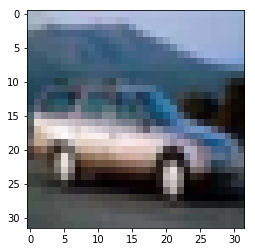

In [3]:
plot_image(4)

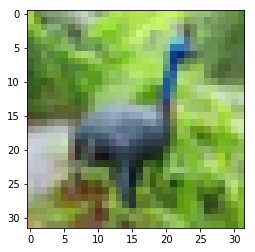

In [4]:
plot_image(6)

We need to do a data conversion to get the class labels in one-hot encoded format.  This will allow us to use a softmax activation and categorical cross-entopy loss in our network.  CIFAR 10 only has 10 distinct classes so this is fairly straightforward.

In [5]:
import keras

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

y_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

The only other pre-processing step to apply is normalizing the input data.  Since everything is an RGB value, we can keep it simple and just divide by 255.

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

Define a few useful configuration items to use throughout the exercise.  The input shape variable will have a value of (32, 32, 3) corresponding to the shape of the array for each image.

In [7]:
in_shape = x_train.shape[1:]
batch_size = 256
n_classes = 10
lr = 0.01

Now we can get started with the actual modeling part.  For a first attempt, let's do the simplest and most naive model possible.  We'll just create a straightforward fully-connected model and stick a softmax activation on at the end.

In [8]:
from keras.models import Model
from keras.layers import Activation, Dense, Flatten, Input
from keras.optimizers import Adam

def SimpleNet(in_shape, layers, n_classes, lr):
    i = Input(shape=in_shape)
    x = Flatten()(i)
    
    for n in range(len(layers)):
        x = Dense(layers[n])(x)
        x = Activation('relu')(x)
    
    x = Dense(n_classes)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

Note that the architecture is somewhat flexible in that we can define as many dense layers as we want by just passing in a list of numbers to the "layers" parameter (where the numbers correspond to the size of the layer).  In this case we're only going to use one layer, but this capability will be very useful later on.

In [9]:
model = SimpleNet(in_shape, [40], n_classes, lr)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 40)                122920    
_________________________________________________________________
activation_1 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                410       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 123,330
Trainable params: 123,330
Non-trainable params: 0
_________________________________________________________________


Our last step before training is to define an image data generator. We could just train on the images as-is, but randomly applying transformations to the images will make the classifier more robust. Keras has a utility class built in for just this purpose, so we can use that randomly shift or flip the direction of the images during training.

In [10]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)

Let's try training for 10 epochs and see what happens!

In [11]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=10, validation_data=(x_test, y_test), workers=4)

Epoch 1/10
196/196 [==============================] - 26s 134ms/step - loss: 2.4531 - acc: 0.0974 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/10
196/196 [==============================] - 23s 120ms/step - loss: 2.2576 - acc: 0.1268 - val_loss: 2.1575 - val_acc: 0.1623
Epoch 3/10
196/196 [==============================] - 24s 120ms/step - loss: 2.1256 - acc: 0.1741 - val_loss: 2.0836 - val_acc: 0.1764
Epoch 4/10
196/196 [==============================] - 24s 122ms/step - loss: 2.1123 - acc: 0.1760 - val_loss: 2.0775 - val_acc: 0.1972
Epoch 5/10
196/196 [==============================] - 23s 119ms/step - loss: 2.0938 - acc: 0.1802 - val_loss: 2.0716 - val_acc: 0.1710
Epoch 6/10
196/196 [==============================] - 24s 120ms/step - loss: 2.0940 - acc: 0.1784 - val_loss: 2.0660 - val_acc: 0.1875
Epoch 7/10
196/196 [==============================] - 24s 121ms/step - loss: 2.0894 - acc: 0.1822 - val_loss: 2.1032 - val_acc: 0.1765
Epoch 8/10
196/196 [==============================] - 2

Clearly the naive approach is not very effective.  The model is basically doing a bit better than randomly guessing.  Let's replace the dense layer with a few convolutional layers instead.  I'm not going to cover convolutional layers in-depth here, there are tons of great resources out there already to learn about them.  If you're new to the concept, I would recommend [this blog series](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) as a starting point.  For our first attempt as using convolutions, we'll use a kernel size of 3 and a stride of 2 (rather than use pooling layers in between the conv layers) and a global max pooling layer to condense the output shape before going through the softmax.

In [12]:
from keras.layers import Conv2D, GlobalMaxPooling2D

def ConvNet(in_shape, layers, n_classes, lr):
    i = Input(shape=in_shape)
    
    for n in range(len(layers)):
        if n == 0:
            x = Conv2D(layers[n], kernel_size=3, strides=2)(i)
        else:
            x = Conv2D(layers[n], kernel_size=3, strides=2)(x)
        x = Activation('relu')(x)
    
    x = GlobalMaxPooling2D()(x)
    x = Dense(n_classes)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

This time let's try using 3 conv layers with an increasing number of filters in each layer.

In [13]:
model = ConvNet(in_shape, [20, 40, 80], n_classes, lr)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 20)        560       
_________________________________________________________________
activation_3 (Activation)    (None, 15, 15, 20)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 40)          7240      
_________________________________________________________________
activation_4 (Activation)    (None, 7, 7, 40)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 80)          28880     
_________________________________________________________________
activation_5 (Activation)    (None, 3, 3, 80)          0         
__________

It'd worth checking your intuition and understanding of what's going on by looking at the summary output and verifying that the numbers make sense.  For instance, why does the first convolutional layer have 560 parameters?  Where does that come from?  Well, we have a kernel size of 3 which creates a 3 x 3 filter (i.e. 9 parameters), but we also have different color channels for a depth of 3, so each filter is really 3 x 3 x 3 = 27 parameters, plus 1 for the bias so 28 per filter.  We specified 20 filters in the first layer, so 28 X 20 = 560.  Try applying similar logic to the second conv layer and see if the result makes sense.

Now that we've got a model, let's try training it using the exact same approach as before.

In [14]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=10, validation_data=(x_test, y_test), workers=4)

Epoch 1/10
196/196 [==============================] - 25s 127ms/step - loss: 1.8725 - acc: 0.3019 - val_loss: 1.7737 - val_acc: 0.3772
Epoch 2/10
196/196 [==============================] - 24s 120ms/step - loss: 1.6342 - acc: 0.4015 - val_loss: 1.5930 - val_acc: 0.4314
Epoch 3/10
196/196 [==============================] - 24s 120ms/step - loss: 1.5503 - acc: 0.4349 - val_loss: 1.5013 - val_acc: 0.4567
Epoch 4/10
196/196 [==============================] - 24s 122ms/step - loss: 1.4848 - acc: 0.4623 - val_loss: 1.4356 - val_acc: 0.4801
Epoch 5/10
196/196 [==============================] - 24s 122ms/step - loss: 1.4493 - acc: 0.4798 - val_loss: 1.3845 - val_acc: 0.4972
Epoch 6/10
196/196 [==============================] - 23s 119ms/step - loss: 1.4186 - acc: 0.4892 - val_loss: 1.3761 - val_acc: 0.5066
Epoch 7/10
196/196 [==============================] - 24s 121ms/step - loss: 1.3999 - acc: 0.4956 - val_loss: 1.3681 - val_acc: 0.5024
Epoch 8/10
196/196 [==============================] - 2

The results are a lot different this time!  The model is clearly learning and after 10 epochs we're at about 50% accuracy on the validation set.  Still, we should be able to do a lot better.  For the next attempt let's introduce a few new wrinkles.  First, we're going to add batch normalization after each conv layer.  Second, we're going to add a single conv layer at the beginning with a larger kernel size and a stride of 1 so we don't reduce the receptive field.  Third, we're going to introduce padding which will modify the shape of each conv layer output.  Finally, we're going to add a few more layers to make the model bigger.

To make the model definition more modular, I've pulled out the conv layer into a separate class.  There are multiple ways to do this (a function would have worked just as well) but I opted to mimic the way Keras's functional API works.

In [15]:
from keras.layers import BatchNormalization

class ConvLayer:
    def __init__(self, filters, kernel_size, stride):
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride

    def __call__(self, x):
        x = Conv2D(self.filters, kernel_size=self.kernel_size,
                   strides=self.stride, padding='same', use_bias=False)(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        return x

def ConvNet2(in_shape, layers, n_classes, lr):
    i = Input(shape=in_shape)
    
    x = Conv2D(layers[0], kernel_size=5, strides=1, padding='same')(i)
    x = Activation('relu')(x)
    
    for n in range(1, len(layers)):
        x = ConvLayer(layers[n], kernel_size=3, stride=2)(x)

    x = GlobalMaxPooling2D()(x)
    x = Dense(n_classes)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [16]:
model = ConvNet2(in_shape, [10, 20, 40, 80, 160], n_classes, lr)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 10)        760       
_________________________________________________________________
activation_7 (Activation)    (None, 32, 32, 10)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 20)        1800      
_________________________________________________________________
activation_8 (Activation)    (None, 16, 16, 20)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 16, 20)        80        
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 40)          7200      
__________

We made a bunch of improvements and the network has a much larger capacity, so let's see what it does.

In [17]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=10, validation_data=(x_test, y_test), workers=4)

Epoch 1/10
196/196 [==============================] - 24s 125ms/step - loss: 1.6451 - acc: 0.4258 - val_loss: 1.5408 - val_acc: 0.4597
Epoch 2/10
196/196 [==============================] - 23s 118ms/step - loss: 1.3130 - acc: 0.5280 - val_loss: 1.7158 - val_acc: 0.4559
Epoch 3/10
196/196 [==============================] - 24s 121ms/step - loss: 1.1669 - acc: 0.5803 - val_loss: 1.5101 - val_acc: 0.5311
Epoch 4/10
196/196 [==============================] - 23s 119ms/step - loss: 1.0642 - acc: 0.6205 - val_loss: 1.3304 - val_acc: 0.5538
Epoch 5/10
196/196 [==============================] - 23s 118ms/step - loss: 0.9887 - acc: 0.6485 - val_loss: 1.2749 - val_acc: 0.5955
Epoch 6/10
196/196 [==============================] - 23s 119ms/step - loss: 0.9264 - acc: 0.6717 - val_loss: 1.3210 - val_acc: 0.5819
Epoch 7/10
196/196 [==============================] - 23s 120ms/step - loss: 0.8812 - acc: 0.6887 - val_loss: 0.9221 - val_acc: 0.6807
Epoch 8/10
196/196 [==============================] - 2

That's a significant improvement!  Our validation accuracy after 10 epochs jumped all the way from ~50% to ~70%.  We're already doing pretty good, but there's one more major addition we can make that should bump performance even higher.  A key addition to modern convolutional networks was the invention of [residual layers](https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035), which introduce an "identity" connection to the output of a block of convolutions.  Below I've added a new "ResLayer" class that inherits from "ConvLayer" but outputs the addition of the original input with the output from the conv layer.  Building on the previous network, we've now added two residual layers to each "block" in the model definition.  These residual layers have a stride of 1 so they don't change the shape of the output.  Finally, we've added a bit of regularization to keep the model from overfitting too badly.

In [18]:
from keras import layers
from keras import regularizers
from keras.layers import Dropout

class ConvLayer:
    def __init__(self, filters, kernel_size, stride):
        self.filters = filters
        self.kernel_size = kernel_size
        self.stride = stride

    def __call__(self, x):
        x = Conv2D(self.filters, kernel_size=self.kernel_size,
                   strides=self.stride, padding='same', use_bias=False,
                   kernel_regularizer=regularizers.l2(1e-6))(x)
        x = Activation('relu')(x)
        x = BatchNormalization()(x)
        return x

class ResLayer(ConvLayer):
    def __call__(self, x):
        return layers.add([x, super().__call__(x)])

def ResNet(in_shape, layers, n_classes, lr):
    i = Input(shape=in_shape)
    
    x = Conv2D(layers[0], kernel_size=7, strides=1, padding='same')(i)
    x = Activation('relu')(x)

    for n in range(1, len(layers)):
        x = ConvLayer(layers[n], kernel_size=3, stride=2)(x)
        x = ResLayer(layers[n], kernel_size=3, stride=1)(x)
        x = ResLayer(layers[n], kernel_size=3, stride=1)(x)

    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.1)(x)
    x = Dense(n_classes)(x)
    x = Activation('softmax')(x)
    
    model = Model(inputs=i, outputs=x)
    opt = Adam(lr=lr)
    model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [19]:
model = ResNet(in_shape, [10, 20, 40, 80, 160], n_classes, lr)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_9 (Conv2D)               (None, 32, 32, 10)   1480        input_4[0][0]                    
__________________________________________________________________________________________________
activation_13 (Activation)      (None, 32, 32, 10)   0           conv2d_9[0][0]                   
__________________________________________________________________________________________________
conv2d_10 (Conv2D)              (None, 16, 16, 20)   1800        activation_13[0][0]              
__________________________________________________________________________________________________
activation

The model summary is now getting quite large, but you can still follow through each layer and make sense of what's happening. Let's run this one last time and see what the results look like. We'll increase the epoch count since deeper networks tend to take longer to train.

In [20]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=40, validation_data=(x_test, y_test), workers=4)

Epoch 1/40
196/196 [==============================] - 28s 145ms/step - loss: 1.9806 - acc: 0.3498 - val_loss: 7.4266 - val_acc: 0.0771
Epoch 2/40
196/196 [==============================] - 23s 118ms/step - loss: 1.5761 - acc: 0.4484 - val_loss: 2.0037 - val_acc: 0.3478
Epoch 3/40
196/196 [==============================] - 24s 124ms/step - loss: 1.5488 - acc: 0.4612 - val_loss: 14.3443 - val_acc: 0.1005
Epoch 4/40
196/196 [==============================] - 24s 122ms/step - loss: 1.6194 - acc: 0.4359 - val_loss: 2.5182 - val_acc: 0.2401
Epoch 5/40
196/196 [==============================] - 24s 121ms/step - loss: 1.5562 - acc: 0.4626 - val_loss: 2.0495 - val_acc: 0.3302
Epoch 6/40
196/196 [==============================] - 24s 121ms/step - loss: 1.6183 - acc: 0.4400 - val_loss: 2.9989 - val_acc: 0.1782
Epoch 7/40
196/196 [==============================] - 24s 121ms/step - loss: 1.4886 - acc: 0.4672 - val_loss: 1.3995 - val_acc: 0.4944
Epoch 8/40
196/196 [==============================] - 

The results look pretty good.  We're starting to hit the point where accuracy improvements are getting harder to come by.  It's definitely possible to keep improving the model with the right tuning and augmentation strategies, however diminishing returns start to kick in relative to the effort involved.  Also, as the network keeps getting bigger (and as we graduate to larger and more complex data sets) it starts becoming much, much harder to build a network from scratch.

Fortunately there's an alternative solution via [transfer learning](https://machinelearningmastery.com/transfer-learning-for-deep-learning/), which takes a model trained on one task and adapts it to another task.  Combined with pre-training, which is the practice of using a model that's already been trained for a given task, we can take very large networks developed by i.e. Google and Facebook and then fine-tune them to work in a custom domain of our choosing.  Below I'll walk throuh an example of how this works by using a pre-trained ImageNet model and adapting it to Kaggle's [dogs vs cats](https://www.kaggle.com/c/dogs-vs-cats) data set.

First get some imports out of the way.  We'll need all of this stuff throughout the exercise.

In [2]:
import numpy as np
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras.layers import Dense, GlobalAveragePooling2D
from keras.models import Model
from keras.optimizers import RMSprop
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

The easiest way to get the data set is via fast.ai's servers, where they've graciously hosted a [single zip file](http://files.fast.ai/data/dogscats.zip) with everything we need.  Extract this to a directory somewhere on your machine and update the "PATH" variable below, and you should be good to go.  We can also specify a few useful constants such as the image dimension and batch size.

In [3]:
PATH = '/home/paperspace/data/dogscats/'
train_dir = f'{PATH}train'
valid_dir = f'{PATH}valid'
size = 224
batch_size = 64

Next we need a generator to apply transformations to the images. As before, we can use the generator Keras has built-in. The only wrinkle is using a specalized preprocessing function designed for ImageNet-like source data (this also comes with Keras and was imported above).

In [4]:
train_datagen = ImageDataGenerator(
    shear_range=0.2,
    zoom_range=0.2,
    preprocessing_function=preprocess_input,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

With CIFAR 10 we had the whole data set loaded into memory, but that strategy usually isn't feasible for larger image databases. In this case we have a bunch of image files in folders on disk as our starting point, and to run a model over these images we want to be able to stream images into memory in batches rather than load everything at once. Fortunately Keras can also handle this scenario natively using the "flow_from_directory" function. We just need to specify the directory, image size, and batch size.

In [5]:
train_generator = train_datagen.flow_from_directory(train_dir,
    target_size=(size, size),
    batch_size=batch_size, class_mode='binary')

val_generator = val_datagen.flow_from_directory(valid_dir,
    shuffle=False,
    target_size=(size, size),
    batch_size=batch_size, class_mode='binary')

Found 23000 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


For the model, we'll use the ResNet-50 architecture with pre-trained weights.  ResNet-50 is a 168-layer architecture that achieved 92% top-5 accuracy on ImageNet classification.  Keras provides both the model architecture and an option to use existing weights out of the box.  The other notable parameter in the model initializer is "include_top", which indicates if we want to include the fully-connected layer at the top of the network.  In our case the answer is no, because we want to "hook into" the model after the last residual block and add our own architecture on top.

In [6]:
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output

After instantiating the pre-trained ResNet-50 model, we can start adding new layers to the architecture.  Let's start with a pooling layer to normalize the tensor shape, then add a fully-connected layer of our own.  Finally, we'll use sigmoid unit for class probability since the task is binary (cat or dog).

In [7]:
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
preds = Dense(1, activation='sigmoid')(x)

Before finishing the model definition and compiling, there's one more notable step.  We need to prevent the "base" layers of the model from participating in the weight update phase of training while we "break in" the new layers we just added.  Since each layer in a Keras model has a "trainable" property, we can just set it to false for all layers in the base architecture.

(Aside: There is apparently some funkiness to using this approach in models that have batch norm layers that can lead to sub-optimal results, especially when doing fine-tuning which we'll get to in a few steps.  I haven't seen a conclusive answer on how to deal with this, and the niave approach seems to work okay for this problem, so I'm not doing anything special to deal with it here but I wanted to point it out as a potential issue one might run into.  There's a lengthly discussion on the subject [here](https://github.com/keras-team/keras/pull/9965)).

In [8]:
model = Model(inputs=base_model.input, outputs=preds)
for layer in base_model.layers: layer.trainable = False
model.compile(optimizer=RMSprop(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])

Training should be pretty familiar, the only wrinkle here is we need to specify the number of batches in an epoch when using the "flow_from_directory" generator.

In [9]:
history = model.fit_generator(train_generator, train_generator.n // batch_size, epochs=3, workers=4,
                              validation_data=val_generator, validation_steps=val_generator.n // batch_size)

Epoch 1/3
359/359 [==============================] - 128s 357ms/step - loss: 0.1738 - acc: 0.9506 - val_loss: 0.0694 - val_acc: 0.9839
Epoch 2/3
359/359 [==============================] - 123s 342ms/step - loss: 0.0809 - acc: 0.9729 - val_loss: 0.1059 - val_acc: 0.9778
Epoch 3/3
359/359 [==============================] - 123s 344ms/step - loss: 0.0717 - acc: 0.9755 - val_loss: 0.1411 - val_acc: 0.9723


These results aren't too bad even with the entire base architecture held constant.  This is partly due to the fact that the training images are quite similar to the images that the architecture was trained on.  If we were fitting the model on something totally different, say medical image classification for instance, transfer learning would still work but it wouldn't be this easy.

The next step is to fine-tune some of the base model by "unfreezing" parts of it and allowing them to update weights during training.  I'm not aware if there are any best practices for fine-tuning or not.  I think it's generally a lot of trial and error.  For this attempt, I unfroze the last residual block in the network and lowered the learning rate by an order of magnitude.

In [10]:
for layer in model.layers[:142]: layer.trainable = False
for layer in model.layers[142:]: layer.trainable = True
model.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit_generator(train_generator, train_generator.n // batch_size, epochs=3, workers=4,
                              validation_data=val_generator, validation_steps=val_generator.n // batch_size)

Epoch 1/3
359/359 [==============================] - 151s 421ms/step - loss: 0.0468 - acc: 0.9826 - val_loss: 1.0175 - val_acc: 0.9098
Epoch 2/3
359/359 [==============================] - 146s 406ms/step - loss: 0.0293 - acc: 0.9903 - val_loss: 0.1305 - val_acc: 0.9829
Epoch 3/3
359/359 [==============================] - 146s 406ms/step - loss: 0.0211 - acc: 0.9938 - val_loss: 0.1197 - val_acc: 0.9849
